# BigTable MTLM - dataset perplexity testing

Aim of this notebook:
1. Generate student + question datasets
2. Generate N sets of encounters
3. Report on agreement between these sets

The error between the datasets (for large N) is the inherent probabilistic error in the model
- How does this translate to tolerances in the $\alpha$ and $\delta$ parameters

## Model perplexity
A model $q$ is used to predict the values of a set of samples, $\mathbf{x}$.  Perplexity is defined as:

\\[{perplex}_{q}(\mathbf{x}) = b^{-\frac{1}{N}\Sigma_{i=1}^{N}{log_{b}(q(x_i))}}\\]

Perplexity is a measure of `surprise' as a divergence from the predictions that are seen in the true values.


In [13]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 10
active_traits = 5


In [14]:
generate_student_name()

'THYDEY JADY '

In [15]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.310970050388737
th 3.897611886887864 7.208581937276601
null-task passrate 0.7310585786300049
all-null passrate 0.20881461345923252
worst cmp chance= 0.3981071705534973
best cmp chance= 0.9979919516614258
worst Pr= 0.010000000000000007
best Pr= 0.9900000000000002
limits 0.9477282576298987 0.9477282576298987
[[1 2 3]
 [7 8 9]]
(2, 3)


In [16]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, n_active=None):
        self.id = qix

#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        n_c =  numpy.random.choice(range(1,n_active))
#         n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.betas[c] = random.uniform(min_diff, max_diff)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.thetas[c] = random.uniform(min_a, max_a)  


In [17]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [18]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [19]:
def create_qs_from_blobs(n_qs, n_clusters, nt=n_traits):
    from sklearn.datasets.samples_generator import make_blobs
    from sklearn.preprocessing import MinMaxScaler
    
    #beta_min,beta_max
    sc = MinMaxScaler(feature_range=(beta_min, beta_max))
    
    X, y = make_blobs(n_samples=n_qs, centers=n_clusters, n_features=nt, cluster_std=2, random_state=666)
#     baseline = numpy.min(X)
#     X = X - baseline
    X = sc.fit_transform(X)

    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()
    
    qns = []
    for qix, (blob, y) in enumerate(zip(X,y)):
        qn = Question(qix, 0,0, nt=nt, nnw=nnw)
        qn.betas = blob
        qn.group = y
        qns.append(qn)
        
    mags = []
    no_comps = []
    for q in qns:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
        
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    qn_table = BigTable((n_qs, nt),min_w=0, max_w=beta_max)    
    return qns, qn_table

In [26]:
def create_qs(n_qs, nt=n_traits, n_active=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, n_active=n_active) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    return master_qs

In [21]:
def create_students(n_students, nt=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)
    
    itemz = array([ s.thetas for s in psi_list ])
#     fig.set_size_inches(10, 10)
    ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
    for i, txt in enumerate(itemz):
        ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
    plt.show()
    
    return psi_list

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [22]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
                while (not passed) and att<user_patience:
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, passed)
                    attempt_n_map[(q.id,psi.id)] += 1
                    attempts.append(tup)
                    print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                    attempts_by_psi[psi.name].append(tup)
                    attempts_by_q[q].append(tup)
                    att += 1
                if (not pass_to_remove) or (pass_to_remove and passed):
                    qs.remove(qix)
                print("len qs is", len(qs))
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

Q:0, difficulty=2.51 across 1 components
Q:1, difficulty=3.99 across 1 components
Q:2, difficulty=2.44 across 1 components
Q:3, difficulty=2.66 across 1 components
Q:4, difficulty=3.69 across 1 components
Q:5, difficulty=2.83 across 1 components
Q:6, difficulty=3.36 across 1 components
Q:7, difficulty=1.41 across 1 components
Q:8, difficulty=3.70 across 1 components
Q:9, difficulty=2.28 across 1 components
Q:10, difficulty=3.08 across 1 components
Q:11, difficulty=3.95 across 1 components
Q:12, difficulty=4.27 across 1 components
Q:13, difficulty=1.06 across 1 components
Q:14, difficulty=4.20 across 1 components
Q:15, difficulty=1.33 across 1 components
Q:16, difficulty=3.26 across 1 components
Q:17, difficulty=1.56 across 1 components
Q:18, difficulty=4.05 across 1 components
Q:19, difficulty=3.02 across 1 components
Q:20, difficulty=2.39 across 1 components
Q:21, difficulty=3.33 across 1 components
Q:22, difficulty=2.71 across 1 components
Q:23, difficulty=1.29 across 1 components
Q:

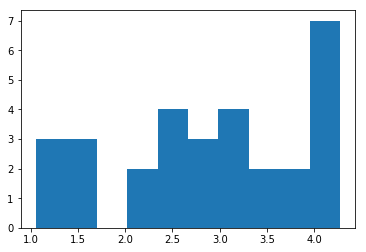

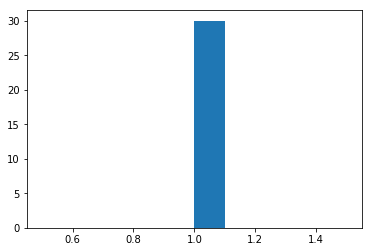

qid 0 [0, 2.5101984971565656]
qid 1 [0, 3.9908759086513483]
qid 2 [2.438204260629469, 0]
qid 3 [0, 2.657559979636604]
qid 4 [0, 3.6863869519682155]
qid 5 [0, 2.8331971792828448]
qid 6 [3.357989328310622, 0]
qid 7 [0, 1.4077197844715144]
qid 8 [0, 3.6976451707487756]
qid 9 [2.2763580066313045, 0]
qid 10 [3.082964235313818, 0]
qid 11 [0, 3.952808142233556]
qid 12 [4.2739462130441614, 0]
qid 13 [0, 1.0555089285925308]
qid 14 [4.203217619253647, 0]
qid 15 [0, 1.3290450545217896]
qid 16 [0, 3.256601545615975]
qid 17 [1.5621063602152172, 0]
qid 18 [4.051585238749421, 0]
qid 19 [0, 3.0213890685932925]
qid 20 [0, 2.390824766984986]
qid 21 [0, 3.3260033151673483]
qid 22 [2.711927802180143, 0]
qid 23 [1.2859320150253666, 0]
qid 24 [0, 4.1789194610983085]
qid 25 [0, 2.030217363515868]
qid 26 [3.0535963213357733, 0]
qid 27 [1.4311972978519223, 0]
qid 28 [3.9839311077484614, 0]
qid 29 [2.749886370868249, 0]
PHUTHY CORE , skill=8.13 across 2 comps
FIW NICHEC , skill=8.13 across 2 comps
CACER RONI , 

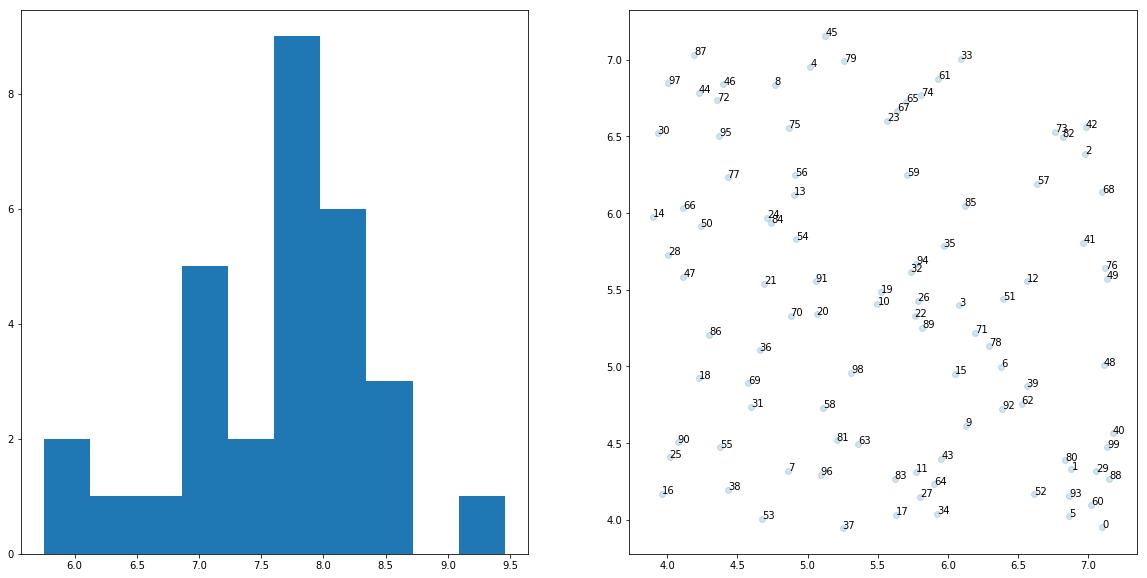

----0

p_pass was 0.9323950731911267 = 1
len qs is 29
p_pass was 0.9906466676208434 = 1
len qs is 28
p_pass was 0.8089067812972042 = 1
len qs is 27
p_pass was 0.753974551472973 = 1
len qs is 26
p_pass was 0.9823266367282542 = 1
len qs is 25
p_pass was 0.9872695097098831 = 1
len qs is 24
p_pass was 0.49056234775343294 = 0
p_pass was 0.49056234775343294 = 0
p_pass was 0.49056234775343294 = 1
len qs is 23
p_pass was 0.5635237816225668 = 1
len qs is 22
p_pass was 0.9477282576298987 = 1
len qs is 21
p_pass was 0.8724618565985444 = 1
len qs is 20
p_pass was 0.9960838528611099 = 1
len qs is 19
p_pass was 0.9575844306292046 = 1
len qs is 18
p_pass was 0.4437889626760882 = 0
p_pass was 0.4437889626760882 = 0
p_pass was 0.4437889626760882 = 1
len qs is 17
p_pass was 0.5662908981849212 = 1
len qs is 16
p_pass was 0.9970260844799264 = 1
len qs is 15
p_pass was 0.9828293366996466 = 1
len qs is 14
p_pass was 0.9877378700765986 = 1
len qs is 13
p_pass was 0.8266825741528392 = 1
len qs is 12
p_pass wa

p_pass was 0.47884710659298857 = 1
len qs is 24
p_pass was 0.8116954700583565 = 0
p_pass was 0.8116954700583565 = 1
len qs is 23
p_pass was 0.9927565025668621 = 1
len qs is 22
p_pass was 0.9650523192180818 = 1
len qs is 21
p_pass was 0.9381552736609168 = 1
len qs is 20
p_pass was 0.9340040176348772 = 1
len qs is 19
p_pass was 0.9218729957504049 = 1
len qs is 18
p_pass was 0.9586198385828156 = 1
len qs is 17
p_pass was 0.693451381950644 = 0
p_pass was 0.693451381950644 = 0
p_pass was 0.693451381950644 = 1
len qs is 16
p_pass was 0.6321100520093279 = 1
len qs is 15
p_pass was 0.9897296467646293 = 1
len qs is 14
p_pass was 0.9904993136842847 = 1
len qs is 13
p_pass was 0.4074113275903247 = 0
p_pass was 0.4074113275903247 = 0
p_pass was 0.4074113275903247 = 1
len qs is 12
p_pass was 0.9317150086099566 = 1
len qs is 11
p_pass was 0.46199439046494606 = 1
len qs is 10
p_pass was 0.9080039624104427 = 1
len qs is 9
p_pass was 0.9504757932729121 = 1
len qs is 8
p_pass was 0.7662652025735273 = 1


p_pass was 0.8911363511775778 = 1
len qs is 22
p_pass was 0.8080716620873972 = 1
len qs is 21
p_pass was 0.8499053779519967 = 1
len qs is 20
p_pass was 0.8509431619069447 = 1
len qs is 19
p_pass was 0.9542432730750003 = 1
len qs is 18
p_pass was 0.9890077570591367 = 1
len qs is 17
p_pass was 0.9875424874563248 = 1
len qs is 16
p_pass was 0.813906528843063 = 1
len qs is 15
p_pass was 0.9188970699700889 = 0
p_pass was 0.9188970699700889 = 1
len qs is 14
p_pass was 0.938879971371999 = 1
len qs is 13
p_pass was 0.8583330416442774 = 1
len qs is 12
p_pass was 0.9305524992247526 = 0
p_pass was 0.9305524992247526 = 1
len qs is 11
p_pass was 0.9676478336481327 = 1
len qs is 10
p_pass was 0.9836872265168778 = 1
len qs is 9
p_pass was 0.9873109679987271 = 1
len qs is 8
p_pass was 0.9541549121503212 = 1
len qs is 7
p_pass was 0.9371728314965325 = 1
len qs is 6
p_pass was 0.8976886837748218 = 1
len qs is 5
p_pass was 0.7772107220793087 = 0
p_pass was 0.7772107220793087 = 0
p_pass was 0.777210722079

p_pass was 0.9479304352716698 = 1
len qs is 11
p_pass was 0.9835797353957006 = 1
len qs is 10
p_pass was 0.9264527844506298 = 1
len qs is 9
p_pass was 0.9513129084518055 = 1
len qs is 8
p_pass was 0.7751546182603131 = 1
len qs is 7
p_pass was 0.9926032382149058 = 1
len qs is 6
p_pass was 0.9840473711421126 = 1
len qs is 5
p_pass was 0.6481334691562973 = 1
len qs is 4
p_pass was 0.9963651297256128 = 1
len qs is 3
p_pass was 0.7062553295130375 = 0
p_pass was 0.7062553295130375 = 1
len qs is 2
p_pass was 0.9591418659593182 = 1
len qs is 1
p_pass was 0.7039143023440627 = 1
len qs is 0
p_pass was 0.9955171310431484 = 1
len qs is 29
p_pass was 0.9405812297170049 = 1
len qs is 28
p_pass was 0.8927177792491232 = 0
p_pass was 0.8927177792491232 = 1
len qs is 27
p_pass was 0.9854458655689875 = 1
len qs is 26
p_pass was 0.973586620804923 = 1
len qs is 25
p_pass was 0.9775767216135997 = 1
len qs is 24
p_pass was 0.979809406127434 = 1
len qs is 23
p_pass was 0.8916347718585368 = 1
len qs is 22
p_pa

p_pass was 0.666536432306053 = 1
len qs is 22
p_pass was 0.6642898635282934 = 1
len qs is 21
p_pass was 0.8728732704171577 = 1
len qs is 20
p_pass was 0.5770875102345208 = 1
len qs is 19
p_pass was 0.9674082145726638 = 1
len qs is 18
p_pass was 0.877026086408976 = 1
len qs is 17
p_pass was 0.6795865197787321 = 1
len qs is 16
p_pass was 0.7285117202351422 = 0
p_pass was 0.7285117202351422 = 1
len qs is 15
p_pass was 0.8351941322707207 = 1
len qs is 14
p_pass was 0.45749145020586246 = 0
p_pass was 0.45749145020586246 = 0
p_pass was 0.45749145020586246 = 0
p_pass was 0.45749145020586246 = 1
len qs is 13
p_pass was 0.9168375427802227 = 1
len qs is 12
p_pass was 0.9358018137434492 = 1
len qs is 11
p_pass was 0.5139128250975961 = 0
p_pass was 0.5139128250975961 = 1
len qs is 10
p_pass was 0.5043993623738486 = 0
p_pass was 0.5043993623738486 = 1
len qs is 9
p_pass was 0.9504034301978693 = 1
len qs is 8
p_pass was 0.8784951757898645 = 1
len qs is 7
p_pass was 0.5798327516387564 = 1
len qs is 6

p_pass was 0.8760340471621153 = 1
len qs is 18
p_pass was 0.9476615523217752 = 1
len qs is 17
p_pass was 0.9768309094387857 = 0
p_pass was 0.9768309094387857 = 1
len qs is 16
p_pass was 0.990634190343248 = 1
len qs is 15
p_pass was 0.9837631225885871 = 1
len qs is 14
p_pass was 0.946733797301092 = 1
len qs is 13
p_pass was 0.987252585298764 = 1
len qs is 12
p_pass was 0.944040327843598 = 1
len qs is 11
p_pass was 0.9740203578275982 = 1
len qs is 10
p_pass was 0.9700191649827016 = 1
len qs is 9
p_pass was 0.8985767093302381 = 1
len qs is 8
p_pass was 0.9960786000381047 = 1
len qs is 7
p_pass was 0.9938112153341245 = 1
len qs is 6
p_pass was 0.9828066121492933 = 1
len qs is 5
p_pass was 0.9965581093016977 = 1
len qs is 4
p_pass was 0.95469171496568 = 1
len qs is 3
p_pass was 0.9574228897978687 = 1
len qs is 2
p_pass was 0.9195813422700009 = 0
p_pass was 0.9195813422700009 = 1
len qs is 1
p_pass was 0.9644672230866592 = 1
len qs is 0
p_pass was 0.8613867830854723 = 1
len qs is 29
p_pass w

p_pass was 0.9613501150844074 = 1
len qs is 4
p_pass was 0.7335486511745757 = 0
p_pass was 0.7335486511745757 = 1
len qs is 3
p_pass was 0.6391458064623621 = 0
p_pass was 0.6391458064623621 = 1
len qs is 2
p_pass was 0.9659286657208277 = 1
len qs is 1
p_pass was 0.9482926783293115 = 1
len qs is 0
p_pass was 0.8748290142820329 = 1
len qs is 29
p_pass was 0.843901914250067 = 1
len qs is 28
p_pass was 0.6658696602901556 = 0
p_pass was 0.6658696602901556 = 1
len qs is 27
p_pass was 0.9216363112287175 = 1
len qs is 26
p_pass was 0.9091205473647015 = 1
len qs is 25
p_pass was 0.9647686061894001 = 0
p_pass was 0.9647686061894001 = 1
len qs is 24
p_pass was 0.9485261089684599 = 1
len qs is 23
p_pass was 0.883831039704419 = 1
len qs is 22
p_pass was 0.6147212503728822 = 1
len qs is 21
p_pass was 0.9924581306237702 = 1
len qs is 20
p_pass was 0.8789384238835751 = 1
len qs is 19
p_pass was 0.6313308471810657 = 1
len qs is 18
p_pass was 0.9045501460046642 = 1
len qs is 17
p_pass was 0.960037915777

len qs is 17
p_pass was 0.8704078596088836 = 1
len qs is 16
p_pass was 0.7386170456275807 = 1
len qs is 15
p_pass was 0.5755467594974142 = 0
p_pass was 0.5755467594974142 = 1
len qs is 14
p_pass was 0.5848186517734807 = 0
p_pass was 0.5848186517734807 = 0
p_pass was 0.5848186517734807 = 1
len qs is 13
p_pass was 0.9343812114115234 = 1
len qs is 12
p_pass was 0.9436338113181163 = 1
len qs is 11
p_pass was 0.8563372863546955 = 1
len qs is 10
p_pass was 0.6942958761410695 = 0
p_pass was 0.6942958761410695 = 0
p_pass was 0.6942958761410695 = 1
len qs is 9
p_pass was 0.9782955535963944 = 1
len qs is 8
p_pass was 0.9472337819117821 = 1
len qs is 7
p_pass was 0.7521842145854687 = 1
len qs is 6
p_pass was 0.8849974414045217 = 1
len qs is 5
p_pass was 0.9715880022947649 = 1
len qs is 4
p_pass was 0.8118685247225911 = 1
len qs is 3
p_pass was 0.7090983671971343 = 1
len qs is 2
p_pass was 0.9059516709619692 = 1
len qs is 1
p_pass was 0.7814276467877606 = 1
len qs is 0
p_pass was 0.938254074250140

p_pass was 0.9121530984604995 = 1
len qs is 13
p_pass was 0.9653877403877752 = 1
len qs is 12
p_pass was 0.9510866551850815 = 1
len qs is 11
p_pass was 0.7877448794924748 = 1
len qs is 10
p_pass was 0.7398067040150653 = 1
len qs is 9
p_pass was 0.9837864285740847 = 1
len qs is 8
p_pass was 0.9166736805466895 = 1
len qs is 7
p_pass was 0.6939927717134579 = 1
len qs is 6
p_pass was 0.8916756027529164 = 0
p_pass was 0.8916756027529164 = 1
len qs is 5
p_pass was 0.8970229319131802 = 1
len qs is 4
p_pass was 0.8983204436878873 = 1
len qs is 3
p_pass was 0.9742198412185422 = 1
len qs is 2
p_pass was 0.9232660919213471 = 1
len qs is 1
p_pass was 0.973144253263149 = 1
len qs is 0
p_pass was 0.9644911454811236 = 1
len qs is 29
p_pass was 0.7068209395942494 = 0
p_pass was 0.7068209395942494 = 1
len qs is 28
p_pass was 0.8922601826607293 = 1
len qs is 27
p_pass was 0.8731358769976142 = 1
len qs is 26
p_pass was 0.8405383813335221 = 1
len qs is 25
p_pass was 0.9631832368791335 = 1
len qs is 24
p_p

p_pass was 0.837298851038333 = 1
len qs is 16
p_pass was 0.9049656035298392 = 1
len qs is 15
p_pass was 0.7914805484825542 = 1
len qs is 14
p_pass was 0.6548160885105747 = 0
p_pass was 0.6548160885105747 = 1
len qs is 13
p_pass was 0.6699438683819043 = 0
p_pass was 0.6699438683819043 = 1
len qs is 12
p_pass was 0.8644622464387557 = 1
len qs is 11
p_pass was 0.7958124971577839 = 1
len qs is 10
p_pass was 0.8786741796080129 = 1
len qs is 9
p_pass was 0.9853736945669629 = 1
len qs is 8
p_pass was 0.9253841012186179 = 1
len qs is 7
p_pass was 0.9538692064686609 = 1
len qs is 6
p_pass was 0.9678893582415374 = 1
len qs is 5
p_pass was 0.9709435261617885 = 1
len qs is 4
p_pass was 0.619787102367223 = 1
len qs is 3
p_pass was 0.6029844809431717 = 1
len qs is 2
p_pass was 0.8631377309122736 = 1
len qs is 1
p_pass was 0.9630544592259499 = 1
len qs is 0
p_pass was 0.9652967462738719 = 1
len qs is 29
p_pass was 0.9643075147485235 = 1
len qs is 28
p_pass was 0.9093148979263787 = 1
len qs is 27
p_pa

p_pass was 0.9775784279922871 = 1
len qs is 11
p_pass was 0.6118633623966595 = 0
p_pass was 0.6118633623966595 = 1
len qs is 10
p_pass was 0.9203080640261339 = 1
len qs is 9
p_pass was 0.8032061820092441 = 1
len qs is 8
p_pass was 0.8554616914540256 = 1
len qs is 7
p_pass was 0.9828522379044353 = 1
len qs is 6
p_pass was 0.7597468091294877 = 1
len qs is 5
p_pass was 0.9757876051807703 = 1
len qs is 4
p_pass was 0.7858989039096629 = 1
len qs is 3
p_pass was 0.8750580911764727 = 1
len qs is 2
p_pass was 0.8708486029862433 = 1
len qs is 1
p_pass was 0.8326844007701355 = 1
len qs is 0
p_pass was 0.6656283734247047 = 1
len qs is 29
p_pass was 0.943334247452202 = 1
len qs is 28
p_pass was 0.48855303180106385 = 1
len qs is 27
p_pass was 0.8255274750638429 = 1
len qs is 26
p_pass was 0.7524799670422665 = 1
len qs is 25
p_pass was 0.9785271170215056 = 1
len qs is 24
p_pass was 0.740244031322838 = 1
len qs is 23
p_pass was 0.7157935679849083 = 0
p_pass was 0.7157935679849083 = 1
len qs is 22
p_p

len qs is 11
p_pass was 0.9930528918523422 = 1
len qs is 10
p_pass was 0.9491888452875231 = 1
len qs is 9
p_pass was 0.9839725912611818 = 1
len qs is 8
p_pass was 0.9175658562513339 = 1
len qs is 7
p_pass was 0.9939865421265055 = 1
len qs is 6
p_pass was 0.9311501938052461 = 1
len qs is 5
p_pass was 0.8506928050643245 = 1
len qs is 4
p_pass was 0.9745130008545981 = 1
len qs is 3
p_pass was 0.8928041335677839 = 1
len qs is 2
p_pass was 0.9647937767142462 = 1
len qs is 1
p_pass was 0.983835564811638 = 1
len qs is 0
p_pass was 0.9951763593716829 = 1
len qs is 29
p_pass was 0.49686419355719913 = 1
len qs is 28
p_pass was 0.5437627726040014 = 1
len qs is 27
p_pass was 0.9328547869231512 = 1
len qs is 26
p_pass was 0.6985437168531894 = 1
len qs is 25
p_pass was 0.9936518071058975 = 1
len qs is 24
p_pass was 0.9944264044363003 = 1
len qs is 23
p_pass was 0.912246365347037 = 0
p_pass was 0.912246365347037 = 1
len qs is 22
p_pass was 0.9848891900857902 = 1
len qs is 21
p_pass was 0.979476278410

p_pass was 0.9902818195149669 = 1
len qs is 14
p_pass was 0.47679307046074115 = 1
len qs is 13
p_pass was 0.6796870159426495 = 1
len qs is 12
p_pass was 0.7420645426066066 = 1
len qs is 11
p_pass was 0.8019291321077139 = 0
p_pass was 0.8019291321077139 = 1
len qs is 10
p_pass was 0.5146802590263903 = 0
p_pass was 0.5146802590263903 = 0
p_pass was 0.5146802590263903 = 1
len qs is 9
p_pass was 0.9820401517492653 = 1
len qs is 8
p_pass was 0.45918525476643424 = 0
p_pass was 0.45918525476643424 = 1
len qs is 7
p_pass was 0.9668868491292062 = 1
len qs is 6
p_pass was 0.9744412916469974 = 1
len qs is 5
p_pass was 0.9125618352818375 = 1
len qs is 4
p_pass was 0.9530382624398277 = 1
len qs is 3
p_pass was 0.8418581206049478 = 1
len qs is 2
p_pass was 0.8850182693770551 = 1
len qs is 1
p_pass was 0.9712937045920832 = 1
len qs is 0
p_pass was 0.9952182307612853 = 1
len qs is 29
p_pass was 0.9821832085249033 = 1
len qs is 28
p_pass was 0.9963584133090443 = 1
len qs is 27
p_pass was 0.947335467588

p_pass was 0.9943391434629683 = 1
len qs is 27
p_pass was 0.9960578593220332 = 1
len qs is 26
p_pass was 0.9817889834348223 = 1
len qs is 25
p_pass was 0.9838049722794655 = 1
len qs is 24
p_pass was 0.9104081549493023 = 1
len qs is 23
p_pass was 0.9695286798850622 = 1
len qs is 22
p_pass was 0.9318077661242223 = 1
len qs is 21
p_pass was 0.9938786253021337 = 1
len qs is 20
p_pass was 0.9426705827435169 = 1
len qs is 19
p_pass was 0.9750192333348018 = 1
len qs is 18
p_pass was 0.9444900233436272 = 1
len qs is 17
p_pass was 0.9956880306149366 = 1
len qs is 16
p_pass was 0.9246082493611155 = 1
len qs is 15
p_pass was 0.9272193500701812 = 0
p_pass was 0.9272193500701812 = 1
len qs is 14
p_pass was 0.9837948080518375 = 1
len qs is 13
p_pass was 0.9876272540501441 = 1
len qs is 12
p_pass was 0.9432759843809444 = 1
len qs is 11
p_pass was 0.9766845896104237 = 1
len qs is 10
p_pass was 0.9597493060465486 = 1
len qs is 9
p_pass was 0.9954443280972572 = 1
len qs is 8
p_pass was 0.927173935084175

p_pass was 0.9969548275901919 = 1
len qs is 28
p_pass was 0.9956746913388526 = 1
len qs is 27
p_pass was 0.7785158689005686 = 1
len qs is 26
p_pass was 0.8276011347999451 = 1
len qs is 25
p_pass was 0.9350958461583061 = 1
len qs is 24
p_pass was 0.9919694517032691 = 1
len qs is 23
p_pass was 0.433638479865196 = 1
len qs is 22
p_pass was 0.4510837603175733 = 0
p_pass was 0.4510837603175733 = 1
len qs is 21
p_pass was 0.9588697622919178 = 1
len qs is 20
p_pass was 0.947541518496834 = 1
len qs is 19
p_pass was 0.7217840694356896 = 1
len qs is 18
p_pass was 0.9786530392464141 = 1
len qs is 17
p_pass was 0.9885226054590142 = 1
len qs is 16
p_pass was 0.8494849052180374 = 1
len qs is 15
p_pass was 0.9201817067988526 = 0
p_pass was 0.9201817067988526 = 1
len qs is 14
p_pass was 0.9850664227578442 = 1
len qs is 13
p_pass was 0.9870861682329173 = 1
len qs is 12
p_pass was 0.4888367461905935 = 0
p_pass was 0.4888367461905935 = 1
len qs is 11
p_pass was 0.959311483396128 = 1
len qs is 10
p_pass w

p_pass was 0.8307431859392735 = 1
len qs is 8
p_pass was 0.9722609663383848 = 1
len qs is 7
p_pass was 0.8555851330217548 = 1
len qs is 6
p_pass was 0.9909634842795437 = 1
len qs is 5
p_pass was 0.9756458418460179 = 1
len qs is 4
p_pass was 0.7139502287880621 = 1
len qs is 3
p_pass was 0.967032661508394 = 1
len qs is 2
p_pass was 0.9610059982539136 = 1
len qs is 1
p_pass was 0.9296990251166092 = 1
len qs is 0
p_pass was 0.8955470685591826 = 1
len qs is 29
p_pass was 0.9854048180551224 = 1
len qs is 28
p_pass was 0.7731844164950652 = 0
p_pass was 0.7731844164950652 = 1
len qs is 27
p_pass was 0.9532237919729821 = 1
len qs is 26
p_pass was 0.9201727693523795 = 1
len qs is 25
p_pass was 0.9398233038771514 = 1
len qs is 24
p_pass was 0.9552160968209005 = 1
len qs is 23
p_pass was 0.9476037435910332 = 1
len qs is 22
p_pass was 0.8044627657675555 = 1
len qs is 21
p_pass was 0.8103816023496173 = 0
p_pass was 0.8103816023496173 = 0
p_pass was 0.8103816023496173 = 1
len qs is 20
p_pass was 0.92

p_pass was 0.6740933686276851 = 1
len qs is 21
p_pass was 0.9896631608238139 = 1
len qs is 20
p_pass was 0.9648317591007518 = 1
len qs is 19
p_pass was 0.8806669297995601 = 1
len qs is 18
p_pass was 0.9336009890641926 = 0
p_pass was 0.9336009890641926 = 1
len qs is 17
p_pass was 0.6242134744569462 = 1
len qs is 16
p_pass was 0.906572438471336 = 1
len qs is 15
p_pass was 0.9684693513073613 = 1
len qs is 14
p_pass was 0.8785205712637711 = 1
len qs is 13
p_pass was 0.9927094668781523 = 1
len qs is 12
p_pass was 0.9809069448088241 = 1
len qs is 11
p_pass was 0.9074578869822321 = 1
len qs is 10
p_pass was 0.7945706091433182 = 1
len qs is 9
p_pass was 0.9728418812501943 = 1
len qs is 8
p_pass was 0.9501679887790561 = 0
p_pass was 0.9501679887790561 = 1
len qs is 7
p_pass was 0.9583604337342589 = 1
len qs is 6
p_pass was 0.6074825824152917 = 0
p_pass was 0.6074825824152917 = 0
p_pass was 0.6074825824152917 = 1
len qs is 5
p_pass was 0.9588528298133671 = 1
len qs is 4
p_pass was 0.659058988231

p_pass was 0.7597468091294877 = 1
len qs is 8
p_pass was 0.6624962036098965 = 0
p_pass was 0.6624962036098965 = 0
p_pass was 0.6624962036098965 = 1
len qs is 7
p_pass was 0.8638331305424074 = 0
p_pass was 0.8638331305424074 = 1
len qs is 6
p_pass was 0.8750580911764727 = 1
len qs is 5
p_pass was 0.6472068261924634 = 1
len qs is 4
p_pass was 0.6118633623966595 = 0
p_pass was 0.6118633623966595 = 0
p_pass was 0.6118633623966595 = 0
p_pass was 0.6118633623966595 = 1
len qs is 3
p_pass was 0.9828522379044353 = 1
len qs is 2
p_pass was 0.7527297013601034 = 1
len qs is 1
p_pass was 0.8892113856882419 = 1
len qs is 0
p_pass was 0.8076607764066488 = 1
len qs is 29
p_pass was 0.9755971199639032 = 1
len qs is 28
p_pass was 0.7837271368164057 = 1
len qs is 27
p_pass was 0.6656283734247047 = 1
len qs is 26
p_pass was 0.44180508090025633 = 1
len qs is 25
p_pass was 0.9318864609268258 = 1
len qs is 24
p_pass was 0.8972919402469367 = 1
len qs is 23
p_pass was 0.9267197622656947 = 0
p_pass was 0.92671

len qs is 5
p_pass was 0.9876562083044075 = 1
len qs is 4
p_pass was 0.983835564811638 = 1
len qs is 3
p_pass was 0.815308878352914 = 1
len qs is 2
p_pass was 0.9647937767142462 = 1
len qs is 1
p_pass was 0.9812098118487035 = 1
len qs is 0
p_pass was 0.9573387849920171 = 1
len qs is 29
p_pass was 0.912246365347037 = 1
len qs is 28
p_pass was 0.49686419355719913 = 1
len qs is 27
p_pass was 0.6177453053526992 = 0
p_pass was 0.6177453053526992 = 1
len qs is 26
p_pass was 0.9802256124531341 = 0
p_pass was 0.9802256124531341 = 1
len qs is 25
p_pass was 0.8551466723596663 = 0
p_pass was 0.8551466723596663 = 1
len qs is 24
p_pass was 0.9944264044363003 = 1
len qs is 23
p_pass was 0.6985437168531894 = 1
len qs is 22
p_pass was 0.9328547869231512 = 1
len qs is 21
p_pass was 0.9284910273222311 = 0
p_pass was 0.9284910273222311 = 1
len qs is 20
p_pass was 0.7913659745824506 = 0
p_pass was 0.7913659745824506 = 1
len qs is 19
p_pass was 0.9629357462857286 = 1
len qs is 18
p_pass was 0.7129540214290

p_pass was 0.9125618352818375 = 1
len qs is 13
p_pass was 0.8622334118211605 = 0
p_pass was 0.8622334118211605 = 1
len qs is 12
p_pass was 0.47679307046074115 = 0
p_pass was 0.47679307046074115 = 0
p_pass was 0.47679307046074115 = 0
p_pass was 0.47679307046074115 = 0
p_pass was 0.47679307046074115 = 1
len qs is 11
p_pass was 0.9439797320056507 = 1
len qs is 10
p_pass was 0.9712937045920832 = 1
len qs is 9
p_pass was 0.9910104820992706 = 1
len qs is 8
p_pass was 0.8888356689798056 = 1
len qs is 7
p_pass was 0.5146802590263903 = 1
len qs is 6
p_pass was 0.5315560146507067 = 1
len qs is 5
p_pass was 0.9744412916469974 = 1
len qs is 4
p_pass was 0.9607783092636326 = 1
len qs is 3
p_pass was 0.9530382624398277 = 1
len qs is 2
p_pass was 0.8019291321077139 = 0
p_pass was 0.8019291321077139 = 1
len qs is 1
p_pass was 0.7958306777168789 = 1
len qs is 0
p_pass was 0.9788346910875549 = 1
len qs is 29
p_pass was 0.9658152580254338 = 1
len qs is 28
p_pass was 0.7966766325700328 = 0
p_pass was 0.79

len qs is 9
p_pass was 0.9409384218861022 = 1
len qs is 8
p_pass was 0.9237605297608271 = 1
len qs is 7
p_pass was 0.9805557736673125 = 1
len qs is 6
p_pass was 0.7673153065298602 = 0
p_pass was 0.7673153065298602 = 1
len qs is 5
p_pass was 0.7604077211060091 = 1
len qs is 4
p_pass was 0.5842627562002959 = 1
len qs is 3
p_pass was 0.863952304097264 = 1
len qs is 2
p_pass was 0.8817406984072053 = 1
len qs is 1
p_pass was 0.9696373206456719 = 1
len qs is 0
p_pass was 0.9695286798850622 = 1
len qs is 29
p_pass was 0.9766845896104237 = 1
len qs is 28
p_pass was 0.9886523358481497 = 1
len qs is 27
p_pass was 0.9948104597009038 = 1
len qs is 26
p_pass was 0.9837948080518375 = 1
len qs is 25
p_pass was 0.9597493060465486 = 1
len qs is 24
p_pass was 0.9938786253021337 = 1
len qs is 23
p_pass was 0.9876272540501441 = 1
len qs is 22
p_pass was 0.9246082493611155 = 1
len qs is 21
p_pass was 0.9318077661242223 = 1
len qs is 20
p_pass was 0.9960578593220332 = 1
len qs is 19
p_pass was 0.98317840467

p_pass was 0.9472337819117821 = 1
len qs is 6
p_pass was 0.6451412278241949 = 0
p_pass was 0.6451412278241949 = 1
len qs is 5
p_pass was 0.9749870232359297 = 1
len qs is 4
p_pass was 0.5755467594974142 = 1
len qs is 3
p_pass was 0.5848186517734807 = 0
p_pass was 0.5848186517734807 = 0
p_pass was 0.5848186517734807 = 1
len qs is 2
p_pass was 0.9715880022947649 = 1
len qs is 1
p_pass was 0.9124833140554875 = 1
len qs is 0
p_pass was 0.996000633079493 = 1
len qs is 29
p_pass was 0.9870861682329173 = 1
len qs is 28
p_pass was 0.971269746997541 = 1
len qs is 27
p_pass was 0.9201817067988526 = 1
len qs is 26
p_pass was 0.7158484106577477 = 1
len qs is 25
p_pass was 0.9350958461583061 = 1
len qs is 24
p_pass was 0.9919694517032691 = 1
len qs is 23
p_pass was 0.7217840694356896 = 1
len qs is 22
p_pass was 0.959311483396128 = 1
len qs is 21
p_pass was 0.9588697622919178 = 1
len qs is 20
p_pass was 0.9456167398320078 = 1
len qs is 19
p_pass was 0.9292830117998718 = 0
p_pass was 0.929283011799871

p_pass was 0.6939927717134579 = 1
len qs is 16
p_pass was 0.9929714459350516 = 1
len qs is 15
p_pass was 0.9232660919213471 = 1
len qs is 14
p_pass was 0.9166736805466895 = 1
len qs is 13
p_pass was 0.9751562232837245 = 1
len qs is 12
p_pass was 0.8418115279529407 = 1
len qs is 11
p_pass was 0.9809921786361668 = 1
len qs is 10
p_pass was 0.9121530984604995 = 1
len qs is 9
p_pass was 0.7398067040150653 = 0
p_pass was 0.7398067040150653 = 0
p_pass was 0.7398067040150653 = 0
p_pass was 0.7398067040150653 = 1
len qs is 8
p_pass was 0.9751256025963865 = 1
len qs is 7
p_pass was 0.973144253263149 = 1
len qs is 6
p_pass was 0.953643521283189 = 1
len qs is 5
p_pass was 0.9919962714111352 = 1
len qs is 4
p_pass was 0.9653877403877752 = 1
len qs is 3
p_pass was 0.7877448794924748 = 0
p_pass was 0.7877448794924748 = 0
p_pass was 0.7877448794924748 = 1
len qs is 2
p_pass was 0.8782950822783161 = 1
len qs is 1
p_pass was 0.8916756027529164 = 1
len qs is 0
p_pass was 0.9080105394709763 = 1
len qs is

p_pass was 0.9074292860634295 = 1
len qs is 28
p_pass was 0.833258341303394 = 1
len qs is 27
p_pass was 0.9180019686185295 = 1
len qs is 26
p_pass was 0.8246779605298197 = 1
len qs is 25
p_pass was 0.9709435261617885 = 1
len qs is 24
p_pass was 0.8631377309122736 = 0
p_pass was 0.8631377309122736 = 1
len qs is 23
p_pass was 0.8301141128845623 = 1
len qs is 22
p_pass was 0.9538692064686609 = 1
len qs is 21
p_pass was 0.9581035972849352 = 1
len qs is 20
p_pass was 0.9469335680897752 = 1
len qs is 19
p_pass was 0.9853736945669629 = 0
p_pass was 0.9853736945669629 = 1
len qs is 18
p_pass was 0.8745690597213814 = 1
len qs is 17
p_pass was 0.6699438683819043 = 1
len qs is 16
p_pass was 0.8644622464387557 = 1
len qs is 15
p_pass was 0.8786741796080129 = 1
len qs is 14
p_pass was 0.9630544592259499 = 1
len qs is 13
p_pass was 0.988834909841574 = 1
len qs is 12
p_pass was 0.7914805484825542 = 1
len qs is 11
p_pass was 0.9049656035298392 = 0
p_pass was 0.9049656035298392 = 1
len qs is 10
p_pass 

len qs is 29
p_pass was 0.6472068261924634 = 0
p_pass was 0.6472068261924634 = 1
len qs is 28
p_pass was 0.8326844007701355 = 1
len qs is 27
p_pass was 0.9668319348983901 = 1
len qs is 26
p_pass was 0.8638331305424074 = 1
len qs is 25
p_pass was 0.9775784279922871 = 1
len qs is 24
p_pass was 0.7597468091294877 = 0
p_pass was 0.7597468091294877 = 1
len qs is 23
p_pass was 0.8750580911764727 = 1
len qs is 22
p_pass was 0.8554616914540256 = 0
p_pass was 0.8554616914540256 = 1
len qs is 21
p_pass was 0.7160965083514398 = 0
p_pass was 0.7160965083514398 = 0
p_pass was 0.7160965083514398 = 1
len qs is 20
p_pass was 0.8892113856882419 = 1
len qs is 19
p_pass was 0.6624962036098965 = 1
len qs is 18
p_pass was 0.9558024833573788 = 1
len qs is 17
p_pass was 0.8049796511670532 = 1
len qs is 16
p_pass was 0.6118633623966595 = 0
p_pass was 0.6118633623966595 = 0
p_pass was 0.6118633623966595 = 1
len qs is 15
p_pass was 0.9618440962443645 = 1
len qs is 14
p_pass was 0.9154452394999835 = 1
len qs is 

len qs is 3
p_pass was 0.5461760045174624 = 0
p_pass was 0.5461760045174624 = 1
len qs is 2
p_pass was 0.7655264082402853 = 1
len qs is 1
p_pass was 0.7602139486706303 = 0
p_pass was 0.7602139486706303 = 0
p_pass was 0.7602139486706303 = 1
len qs is 0
p_pass was 0.9546470120974753 = 1
len qs is 29
p_pass was 0.9876562083044075 = 1
len qs is 28
p_pass was 0.8985383791654663 = 1
len qs is 27
p_pass was 0.9491888452875231 = 1
len qs is 26
p_pass was 0.8993875592834408 = 1
len qs is 25
p_pass was 0.9679372703083908 = 1
len qs is 24
p_pass was 0.9175658562513339 = 1
len qs is 23
p_pass was 0.815308878352914 = 1
len qs is 22
p_pass was 0.8521171242222297 = 1
len qs is 21
p_pass was 0.9180619418647776 = 1
len qs is 20
p_pass was 0.9657778064106248 = 1
len qs is 19
p_pass was 0.8920339188736023 = 1
len qs is 18
p_pass was 0.8095076905241164 = 1
len qs is 17
p_pass was 0.778814452053877 = 0
p_pass was 0.778814452053877 = 1
len qs is 16
p_pass was 0.9123018820536515 = 1
len qs is 15
p_pass was 0

p_pass was 0.995121800893788 = 1
len qs is 3
p_pass was 0.9870673613777383 = 1
len qs is 2
p_pass was 0.9831804178798083 = 1
len qs is 1
p_pass was 0.9522402991924194 = 1
len qs is 0
p_pass was 0.7958306777168789 = 0
p_pass was 0.7958306777168789 = 1
len qs is 29
p_pass was 0.7364035474055121 = 1
len qs is 28
p_pass was 0.9530382624398277 = 1
len qs is 27
p_pass was 0.9744412916469974 = 1
len qs is 26
p_pass was 0.9357836141608823 = 1
len qs is 25
p_pass was 0.6796870159426495 = 1
len qs is 24
p_pass was 0.47679307046074115 = 1
len qs is 23
p_pass was 0.9820401517492653 = 1
len qs is 22
p_pass was 0.9902818195149669 = 1
len qs is 21
p_pass was 0.9373625992215296 = 1
len qs is 20
p_pass was 0.9439797320056507 = 1
len qs is 19
p_pass was 0.9607783092636326 = 1
len qs is 18
p_pass was 0.8622334118211605 = 1
len qs is 17
p_pass was 0.8019291321077139 = 1
len qs is 16
p_pass was 0.8888356689798056 = 1
len qs is 15
p_pass was 0.8850182693770551 = 1
len qs is 14
p_pass was 0.9910104820992706 

p_pass was 0.6945698583964072 = 1
len qs is 12
p_pass was 0.9604627440732992 = 1
len qs is 11
p_pass was 0.629096075744652 = 1
len qs is 10
p_pass was 0.974528535202275 = 1
len qs is 9
p_pass was 0.8936322650106924 = 0
p_pass was 0.8936322650106924 = 0
p_pass was 0.8936322650106924 = 1
len qs is 8
p_pass was 0.8172502713662092 = 1
len qs is 7
p_pass was 0.6379340868968437 = 0
p_pass was 0.6379340868968437 = 0
p_pass was 0.6379340868968437 = 1
len qs is 6
p_pass was 0.8959399301377445 = 1
len qs is 5
p_pass was 0.8931699027624109 = 1
len qs is 4
p_pass was 0.9805557736673125 = 1
len qs is 3
p_pass was 0.7725155502140798 = 1
len qs is 2
p_pass was 0.7175933822897373 = 1
len qs is 1
p_pass was 0.8436999880649152 = 0
p_pass was 0.8436999880649152 = 1
len qs is 0
p_pass was 0.9956880306149366 = 1
len qs is 29
p_pass was 0.9948104597009038 = 1
len qs is 28
p_pass was 0.9597493060465486 = 1
len qs is 27
p_pass was 0.9104081549493023 = 1
len qs is 26
p_pass was 0.9271739350841758 = 1
len qs is

p_pass was 0.881974502287502 = 1
len qs is 4
p_pass was 0.6942958761410695 = 1
len qs is 3
p_pass was 0.9510305467228792 = 1
len qs is 2
p_pass was 0.837240069733869 = 1
len qs is 1
p_pass was 0.9749870232359297 = 1
len qs is 0
p_pass was 0.959311483396128 = 1
len qs is 29
p_pass was 0.9850664227578442 = 1
len qs is 28
p_pass was 0.9919694517032691 = 1
len qs is 27
p_pass was 0.9350958461583061 = 1
len qs is 26
p_pass was 0.9292830117998718 = 1
len qs is 25
p_pass was 0.9956746913388526 = 1
len qs is 24
p_pass was 0.7217840694356896 = 1
len qs is 23
p_pass was 0.8276011347999451 = 1
len qs is 22
p_pass was 0.996000633079493 = 1
len qs is 21
p_pass was 0.9456167398320078 = 1
len qs is 20
p_pass was 0.9382540742501405 = 1
len qs is 19
p_pass was 0.971269746997541 = 1
len qs is 18
p_pass was 0.947541518496834 = 1
len qs is 17
p_pass was 0.9786530392464141 = 0
p_pass was 0.9786530392464141 = 1
len qs is 16
p_pass was 0.7849917822341056 = 1
len qs is 15
p_pass was 0.9201817067988526 = 1
len

p_pass was 0.8862237879389641 = 0
p_pass was 0.8862237879389641 = 1
len qs is 26
p_pass was 0.9820853669022521 = 1
len qs is 25
p_pass was 0.9710062954551707 = 1
len qs is 24
p_pass was 0.9728975854782096 = 1
len qs is 23
p_pass was 0.9959630169842297 = 1
len qs is 22
p_pass was 0.685838012212293 = 0
p_pass was 0.685838012212293 = 0
p_pass was 0.685838012212293 = 0
p_pass was 0.685838012212293 = 0
p_pass was 0.685838012212293 = 0
p_pass was 0.685838012212293 = 1
len qs is 21
p_pass was 0.6202754714496572 = 1
len qs is 20
p_pass was 0.9784557894751316 = 1
len qs is 19
p_pass was 0.8469746945586014 = 1
len qs is 18
p_pass was 0.8431294551494382 = 1
len qs is 17
p_pass was 0.9918942288485171 = 1
len qs is 16
p_pass was 0.9655592342888795 = 1
len qs is 15
p_pass was 0.9584974636629671 = 1
len qs is 14
p_pass was 0.6367871009033981 = 0
p_pass was 0.6367871009033981 = 0
p_pass was 0.6367871009033981 = 1
len qs is 13
p_pass was 0.9869658042696231 = 1
len qs is 12
p_pass was 0.9849275211174089

p_pass was 0.988834909841574 = 1
len qs is 15
p_pass was 0.6699438683819043 = 1
len qs is 14
p_pass was 0.8745690597213814 = 1
len qs is 13
p_pass was 0.8631377309122736 = 1
len qs is 12
p_pass was 0.9678893582415374 = 1
len qs is 11
p_pass was 0.837298851038333 = 1
len qs is 10
p_pass was 0.8246779605298197 = 0
p_pass was 0.8246779605298197 = 1
len qs is 9
p_pass was 0.833258341303394 = 1
len qs is 8
p_pass was 0.9709435261617885 = 1
len qs is 7
p_pass was 0.9538692064686609 = 1
len qs is 6
p_pass was 0.9049656035298392 = 1
len qs is 5
p_pass was 0.8786741796080129 = 1
len qs is 4
p_pass was 0.9373825325997324 = 1
len qs is 3
p_pass was 0.9180019686185295 = 1
len qs is 2
p_pass was 0.984195418003669 = 1
len qs is 1
p_pass was 0.619787102367223 = 0
p_pass was 0.619787102367223 = 0
p_pass was 0.619787102367223 = 0
p_pass was 0.619787102367223 = 0
p_pass was 0.619787102367223 = 1
len qs is 0
p_pass was 0.9172698081224011 = 1
len qs is 29
p_pass was 0.9495910495189557 = 1
len qs is 28
p_p

p_pass was 0.8032061820092441 = 1
len qs is 26
p_pass was 0.8326844007701355 = 0
p_pass was 0.8326844007701355 = 1
len qs is 25
p_pass was 0.8638331305424074 = 1
len qs is 24
p_pass was 0.8285527608049542 = 1
len qs is 23
p_pass was 0.9154452394999835 = 1
len qs is 22
p_pass was 0.906438385947289 = 1
len qs is 21
p_pass was 0.9020457684924043 = 1
len qs is 20
p_pass was 0.9775784279922871 = 1
len qs is 19
p_pass was 0.9618440962443645 = 1
len qs is 18
p_pass was 0.9304680608561801 = 1
len qs is 17
p_pass was 0.7160965083514398 = 1
len qs is 16
p_pass was 0.7527297013601034 = 1
len qs is 15
p_pass was 0.9558024833573788 = 1
len qs is 14
p_pass was 0.8892113856882419 = 1
len qs is 13
p_pass was 0.9757876051807703 = 1
len qs is 12
p_pass was 0.8049796511670532 = 1
len qs is 11
p_pass was 0.9828522379044353 = 1
len qs is 10
p_pass was 0.937805457881954 = 1
len qs is 9
p_pass was 0.8708486029862433 = 0
p_pass was 0.8708486029862433 = 1
len qs is 8
p_pass was 0.8554616914540256 = 1
len qs is

len qs is 13
p_pass was 0.9824913506046424 = 1
len qs is 12
p_pass was 0.9733726540324374 = 1
len qs is 11
p_pass was 0.955159882617888 = 1
len qs is 10
p_pass was 0.9965952169625504 = 1
len qs is 9
p_pass was 0.9579698729524297 = 1
len qs is 8
p_pass was 0.7873295110753191 = 1
len qs is 7
p_pass was 0.9318666740547623 = 1
len qs is 6
p_pass was 0.7341287295190227 = 1
len qs is 5
p_pass was 0.9446121703096892 = 1
len qs is 4
p_pass was 0.7892085088897028 = 1
len qs is 3
p_pass was 0.9829894465956381 = 1
len qs is 2
p_pass was 0.9878527754625143 = 1
len qs is 1
p_pass was 0.8429766503886841 = 1
len qs is 0
p_pass was 0.8680298398995323 = 1
len qs is 29
p_pass was 0.9391658070685446 = 1
len qs is 28
p_pass was 0.9966669228305954 = 1
len qs is 27
p_pass was 0.8007706249035647 = 1
len qs is 26
p_pass was 0.9274826428363482 = 1
len qs is 25
p_pass was 0.9833429052674646 = 1
len qs is 24
p_pass was 0.9962025152287359 = 1
len qs is 23
p_pass was 0.9457190277402752 = 1
len qs is 22
p_pass was 

p_pass was 0.775400762536636 = 1
len qs is 15
p_pass was 0.6235838670968148 = 0
p_pass was 0.6235838670968148 = 1
len qs is 14
p_pass was 0.8137062710443989 = 1
len qs is 13
p_pass was 0.9689361808540372 = 1
len qs is 12
p_pass was 0.76308366063527 = 1
len qs is 11
p_pass was 0.7980895617297024 = 0
p_pass was 0.7980895617297024 = 1
len qs is 10
p_pass was 0.6919554064148801 = 1
len qs is 9
p_pass was 0.8405688540658187 = 1
len qs is 8
p_pass was 0.6895505101719283 = 1
len qs is 7
p_pass was 0.9216837138900245 = 1
len qs is 6
p_pass was 0.9806804742273698 = 1
len qs is 5
p_pass was 0.9780377102446196 = 0
p_pass was 0.9780377102446196 = 1
len qs is 4
p_pass was 0.7869675424889757 = 1
len qs is 3
p_pass was 0.9314028777813521 = 1
len qs is 2
p_pass was 0.7473222446221691 = 1
len qs is 1
p_pass was 0.7604430572682455 = 1
len qs is 0
p_pass was 0.9604414705903308 = 1
len qs is 29
p_pass was 0.862919488384839 = 1
len qs is 28
p_pass was 0.7118886387643549 = 1
len qs is 27
p_pass was 0.959885

len qs is 4
p_pass was 0.7582012903065541 = 1
len qs is 3
p_pass was 0.9395107981291226 = 1
len qs is 2
p_pass was 0.8672797047010288 = 1
len qs is 1
p_pass was 0.9612536535006326 = 1
len qs is 0
p_pass was 0.9645290766084667 = 1
len qs is 29
p_pass was 0.981539453663764 = 1
len qs is 28
p_pass was 0.8700531829669427 = 0
p_pass was 0.8700531829669427 = 1
len qs is 27
p_pass was 0.9814384043809018 = 1
len qs is 26
p_pass was 0.9887837843711395 = 1
len qs is 25
p_pass was 0.9248073549602221 = 1
len qs is 24
p_pass was 0.9845734196105714 = 1
len qs is 23
p_pass was 0.9541963413182232 = 1
len qs is 22
p_pass was 0.9965304976479945 = 1
len qs is 21
p_pass was 0.943234927742417 = 1
len qs is 20
p_pass was 0.996247576294999 = 1
len qs is 19
p_pass was 0.7419638405728112 = 1
len qs is 18
p_pass was 0.9525034983321508 = 1
len qs is 17
p_pass was 0.9749938730488295 = 1
len qs is 16
p_pass was 0.9274047498421143 = 1
len qs is 15
p_pass was 0.9973586089462477 = 1
len qs is 14
p_pass was 0.97663130

len qs is 0
p_pass was 0.9871244391298555 = 1
len qs is 29
p_pass was 0.918200337233134 = 1
len qs is 28
p_pass was 0.9530663748212735 = 1
len qs is 27
p_pass was 0.9177308985916515 = 1
len qs is 26
p_pass was 0.8179002234695593 = 1
len qs is 25
p_pass was 0.816016830151298 = 1
len qs is 24
p_pass was 0.9743766226424977 = 1
len qs is 23
p_pass was 0.93383332841198 = 1
len qs is 22
p_pass was 0.9854287360695287 = 1
len qs is 21
p_pass was 0.8487135365023085 = 0
p_pass was 0.8487135365023085 = 1
len qs is 20
p_pass was 0.8571968767290292 = 1
len qs is 19
p_pass was 0.9657072755973317 = 1
len qs is 18
p_pass was 0.9445545075983233 = 1
len qs is 17
p_pass was 0.9889060541025255 = 1
len qs is 16
p_pass was 0.8475743998353835 = 1
len qs is 15
p_pass was 0.9553918078749406 = 1
len qs is 14
p_pass was 0.8281986519389548 = 1
len qs is 13
p_pass was 0.9636553041838805 = 1
len qs is 12
p_pass was 0.8425910122576306 = 1
len qs is 11
p_pass was 0.970681332484369 = 1
len qs is 10
p_pass was 0.936622

p_pass was 0.9939159749984102 = 1
len qs is 20
p_pass was 0.9166736805466895 = 1
len qs is 19
p_pass was 0.973144253263149 = 1
len qs is 18
p_pass was 0.953643521283189 = 1
len qs is 17
p_pass was 0.9809651113414494 = 1
len qs is 16
p_pass was 0.8782950822783161 = 1
len qs is 15
p_pass was 0.7877448794924748 = 1
len qs is 14
p_pass was 0.9121530984604995 = 1
len qs is 13
p_pass was 0.9929714459350516 = 1
len qs is 12
p_pass was 0.9742198412185422 = 1
len qs is 11
p_pass was 0.9643929082001149 = 1
len qs is 10
p_pass was 0.9113582386760856 = 0
p_pass was 0.9113582386760856 = 1
len qs is 9
p_pass was 0.9510866551850815 = 1
len qs is 8
p_pass was 0.9232660919213471 = 1
len qs is 7
p_pass was 0.9313073737060391 = 0
p_pass was 0.9313073737060391 = 1
len qs is 6
p_pass was 0.7398067040150653 = 1
len qs is 5
p_pass was 0.7858563749863462 = 1
len qs is 4
p_pass was 0.7324123255343179 = 1
len qs is 3
p_pass was 0.8916756027529164 = 1
len qs is 2
p_pass was 0.9653877403877752 = 1
len qs is 1
p_p

p_pass was 0.9360749170825213 = 1
len qs is 4
p_pass was 0.7028997799302548 = 0
p_pass was 0.7028997799302548 = 0
p_pass was 0.7028997799302548 = 1
len qs is 3
p_pass was 0.9105325361119286 = 1
len qs is 2
p_pass was 0.9742482890705108 = 1
len qs is 1
p_pass was 0.9864273741740803 = 1
len qs is 0
p_pass was 0.833258341303394 = 1
len qs is 29
p_pass was 0.619787102367223 = 0
p_pass was 0.619787102367223 = 1
len qs is 28
p_pass was 0.8246779605298197 = 1
len qs is 27
p_pass was 0.8631377309122736 = 1
len qs is 26
p_pass was 0.7914805484825542 = 1
len qs is 25
p_pass was 0.9538692064686609 = 1
len qs is 24
p_pass was 0.988834909841574 = 1
len qs is 23
p_pass was 0.9373825325997324 = 0
p_pass was 0.9373825325997324 = 1
len qs is 22
p_pass was 0.9469335680897752 = 1
len qs is 21
p_pass was 0.9709435261617885 = 1
len qs is 20
p_pass was 0.6029844809431717 = 1
len qs is 19
p_pass was 0.984195418003669 = 1
len qs is 18
p_pass was 0.6548160885105747 = 0
p_pass was 0.6548160885105747 = 1
len qs 

p_pass was 0.8540991795715904 = 1
len qs is 5
p_pass was 0.8896322385840063 = 1
len qs is 4
p_pass was 0.9885198606346763 = 1
len qs is 3
p_pass was 0.9211904009401715 = 1
len qs is 2
p_pass was 0.8793624706412123 = 1
len qs is 1
p_pass was 0.8450628758426946 = 0
p_pass was 0.8450628758426946 = 0
p_pass was 0.8450628758426946 = 1
len qs is 0
p_pass was 0.9020457684924043 = 1
len qs is 29
p_pass was 0.937805457881954 = 1
len qs is 28
p_pass was 0.9203080640261339 = 1
len qs is 27
p_pass was 0.9618440962443645 = 1
len qs is 26
p_pass was 0.9775784279922871 = 1
len qs is 25
p_pass was 0.8326844007701355 = 1
len qs is 24
p_pass was 0.5949394234381274 = 0
p_pass was 0.5949394234381274 = 1
len qs is 23
p_pass was 0.8892113856882419 = 1
len qs is 22
p_pass was 0.8750580911764727 = 0
p_pass was 0.8750580911764727 = 1
len qs is 21
p_pass was 0.6624962036098965 = 1
len qs is 20
p_pass was 0.7527297013601034 = 1
len qs is 19
p_pass was 0.6472068261924634 = 0
p_pass was 0.6472068261924634 = 1
len 

len qs is 10
p_pass was 0.49071877980610995 = 0
p_pass was 0.49071877980610995 = 0
p_pass was 0.49071877980610995 = 1
len qs is 9
p_pass was 0.7065792409530243 = 1
len qs is 8
p_pass was 0.9898918105727742 = 1
len qs is 7
p_pass was 0.7655264082402853 = 1
len qs is 6
p_pass was 0.9016460746912319 = 0
p_pass was 0.9016460746912319 = 1
len qs is 5
p_pass was 0.9798279184568504 = 1
len qs is 4
p_pass was 0.9713203915991903 = 1
len qs is 3
p_pass was 0.9922922079079973 = 1
len qs is 2
p_pass was 0.8765826247540547 = 0
p_pass was 0.8765826247540547 = 1
len qs is 1
p_pass was 0.9628786387233021 = 1
len qs is 0
p_pass was 0.9180619418647776 = 1
len qs is 29
p_pass was 0.9311501938052461 = 1
len qs is 28
p_pass was 0.9939865421265055 = 1
len qs is 27
p_pass was 0.8506928050643245 = 1
len qs is 26
p_pass was 0.8095076905241164 = 1
len qs is 25
p_pass was 0.9754390032790884 = 1
len qs is 24
p_pass was 0.8993875592834408 = 1
len qs is 23
p_pass was 0.9175658562513339 = 1
len qs is 22
p_pass was 0

p_pass was 0.9390567552403174 = 1
len qs is 18
p_pass was 0.8177750515671802 = 1
len qs is 17
p_pass was 0.96769845601191 = 1
len qs is 16
p_pass was 0.9909472385401905 = 1
len qs is 15
p_pass was 0.995121800893788 = 1
len qs is 14
p_pass was 0.9880927722259766 = 1
len qs is 13
p_pass was 0.8482102121690482 = 1
len qs is 12
p_pass was 0.9340705472002548 = 1
len qs is 11
p_pass was 0.9759768224335721 = 1
len qs is 10
p_pass was 0.9126615003914939 = 1
len qs is 9
p_pass was 0.9543236346469172 = 1
len qs is 8
p_pass was 0.9538303707229552 = 1
len qs is 7
p_pass was 0.9831804178798083 = 1
len qs is 6
p_pass was 0.9273642602484243 = 1
len qs is 5
p_pass was 0.9522402991924194 = 1
len qs is 4
p_pass was 0.9697988086908698 = 1
len qs is 3
p_pass was 0.9632565128420367 = 1
len qs is 2
p_pass was 0.9870673613777383 = 1
len qs is 1
p_pass was 0.9862567065725713 = 1
len qs is 0
p_pass was 0.9530382624398277 = 1
len qs is 29
p_pass was 0.9373625992215296 = 1
len qs is 28
p_pass was 0.9910104820992

p_pass was 0.9655189611406712 = 1
len qs is 6
p_pass was 0.5520224591460796 = 1
len qs is 5
p_pass was 0.9419654619427944 = 1
len qs is 4
p_pass was 0.867331370674012 = 1
len qs is 3
p_pass was 0.6684932532030762 = 1
len qs is 2
p_pass was 0.9285462177628478 = 1
len qs is 1
p_pass was 0.7560535639515346 = 1
len qs is 0
p_pass was 0.8172502713662092 = 1
len qs is 29
p_pass was 0.5842627562002959 = 1
len qs is 28
p_pass was 0.974528535202275 = 1
len qs is 27
p_pass was 0.8959399301377445 = 1
len qs is 26
p_pass was 0.9696373206456719 = 1
len qs is 25
p_pass was 0.9233670347034876 = 1
len qs is 24
p_pass was 0.6969529604844298 = 1
len qs is 23
p_pass was 0.7794759863086274 = 1
len qs is 22
p_pass was 0.8936322650106924 = 1
len qs is 21
p_pass was 0.9573645037122926 = 1
len qs is 20
p_pass was 0.7604077211060091 = 1
len qs is 19
p_pass was 0.6945698583964072 = 0
p_pass was 0.6945698583964072 = 0
p_pass was 0.6945698583964072 = 1
len qs is 18
p_pass was 0.9604627440732992 = 1
len qs is 17
p

p_pass was 0.9626263465929884 = 1
len qs is 9
p_pass was 0.9839280317446356 = 1
len qs is 8
p_pass was 0.8902489802963485 = 0
p_pass was 0.8902489802963485 = 1
len qs is 7
p_pass was 0.8734087845365796 = 1
len qs is 6
p_pass was 0.9943826150670241 = 1
len qs is 5
p_pass was 0.9430818325391392 = 1
len qs is 4
p_pass was 0.9702265285601333 = 1
len qs is 3
p_pass was 0.911038495435956 = 1
len qs is 2
p_pass was 0.9562158932465538 = 1
len qs is 1
p_pass was 0.7333440105942248 = 1
len qs is 0
p_pass was 0.7814276467877606 = 1
len qs is 29
p_pass was 0.9715880022947649 = 1
len qs is 28
p_pass was 0.9436338113181163 = 0
p_pass was 0.9436338113181163 = 1
len qs is 27
p_pass was 0.7249981385559379 = 1
len qs is 26
p_pass was 0.9343812114115234 = 1
len qs is 25
p_pass was 0.881974502287502 = 1
len qs is 24
p_pass was 0.6477143853531954 = 1
len qs is 23
p_pass was 0.9154675083859113 = 1
len qs is 22
p_pass was 0.8502085106743372 = 1
len qs is 21
p_pass was 0.8849974414045217 = 1
len qs is 20
p_pa

p_pass was 0.8823399071409582 = 1
len qs is 24
p_pass was 0.6710810601026179 = 0
p_pass was 0.6710810601026179 = 0
p_pass was 0.6710810601026179 = 1
len qs is 23
p_pass was 0.9959630169842297 = 1
len qs is 22
p_pass was 0.947072339980767 = 1
len qs is 21
p_pass was 0.9884154727478338 = 1
len qs is 20
p_pass was 0.9233179381176251 = 0
p_pass was 0.9233179381176251 = 1
len qs is 19
p_pass was 0.9728975854782096 = 1
len qs is 18
p_pass was 0.9345230478080714 = 1
len qs is 17
p_pass was 0.8431294551494382 = 1
len qs is 16
p_pass was 0.9849275211174089 = 1
len qs is 15
p_pass was 0.9609304062023041 = 1
len qs is 14
p_pass was 0.8032408963300679 = 1
len qs is 13
p_pass was 0.8862237879389641 = 1
len qs is 12
p_pass was 0.9918942288485171 = 1
len qs is 11
p_pass was 0.9869658042696231 = 1
len qs is 10
p_pass was 0.685838012212293 = 1
len qs is 9
p_pass was 0.9110448303934178 = 1
len qs is 8
p_pass was 0.9584974636629671 = 1
len qs is 7
p_pass was 0.9589430118938851 = 1
len qs is 6
p_pass was 

p_pass was 0.9011006705314304 = 1
len qs is 22
p_pass was 0.9641238089837953 = 1
len qs is 21
p_pass was 0.9944871834192262 = 1
len qs is 20
p_pass was 0.9659824724248793 = 1
len qs is 19
p_pass was 0.7847487478978373 = 1
len qs is 18
p_pass was 0.994902153872668 = 1
len qs is 17
p_pass was 0.9481041806114222 = 1
len qs is 16
p_pass was 0.9340148847287777 = 1
len qs is 15
p_pass was 0.931629605697959 = 1
len qs is 14
p_pass was 0.9186356127453507 = 0
p_pass was 0.9186356127453507 = 1
len qs is 13
p_pass was 0.9729193636431375 = 1
len qs is 12
p_pass was 0.9456062012472333 = 1
len qs is 11
p_pass was 0.9810219418188625 = 1
len qs is 10
p_pass was 0.9897751216503228 = 1
len qs is 9
p_pass was 0.9835795793850816 = 1
len qs is 8
p_pass was 0.9251110567110289 = 1
len qs is 7
p_pass was 0.9230508575761338 = 0
p_pass was 0.9230508575761338 = 1
len qs is 6
p_pass was 0.9436204482219666 = 1
len qs is 5
p_pass was 0.9961174089265101 = 1
len qs is 4
p_pass was 0.9863674930419416 = 1
len qs is 3
p

p_pass was 0.5044145278278964 = 0
p_pass was 0.5044145278278964 = 1
len qs is 15
p_pass was 0.8484908391150523 = 1
len qs is 14
p_pass was 0.958861766801345 = 1
len qs is 13
p_pass was 0.540112308575065 = 1
len qs is 12
p_pass was 0.7048652703891531 = 1
len qs is 11
p_pass was 0.9464769714675768 = 1
len qs is 10
p_pass was 0.8233219334814595 = 1
len qs is 9
p_pass was 0.8437474397994358 = 1
len qs is 8
p_pass was 0.5946340079452653 = 1
len qs is 7
p_pass was 0.7458787751624429 = 1
len qs is 6
p_pass was 0.7640816640729992 = 1
len qs is 5
p_pass was 0.622208516707865 = 1
len qs is 4
p_pass was 0.7944199555526904 = 1
len qs is 3
p_pass was 0.9462179404061315 = 1
len qs is 2
p_pass was 0.942070766767218 = 1
len qs is 1
p_pass was 0.8804329779344693 = 1
len qs is 0
p_pass was 0.9226416537827583 = 1
len qs is 29
p_pass was 0.9248608676861313 = 1
len qs is 28
p_pass was 0.9933056909920727 = 1
len qs is 27
p_pass was 0.6661221269754224 = 1
len qs is 26
p_pass was 0.9136799712311714 = 1
len qs

p_pass was 0.5531899639071111 = 0
p_pass was 0.5531899639071111 = 1
len qs is 8
p_pass was 0.7913659745824506 = 1
len qs is 7
p_pass was 0.987118081599254 = 1
len qs is 6
p_pass was 0.9404003667649289 = 1
len qs is 5
p_pass was 0.9944264044363003 = 1
len qs is 4
p_pass was 0.9284910273222311 = 1
len qs is 3
p_pass was 0.839724220242346 = 1
len qs is 2
p_pass was 0.9951763593716829 = 1
len qs is 1
p_pass was 0.8188856853511358 = 0
p_pass was 0.8188856853511358 = 1
len qs is 0
p_pass was 0.9036354856922806 = 1
len qs is 29
p_pass was 0.8351941322707207 = 1
len qs is 28
p_pass was 0.9168375427802227 = 1
len qs is 27
p_pass was 0.7889325306844758 = 0
p_pass was 0.7889325306844758 = 1
len qs is 26
p_pass was 0.8784951757898645 = 1
len qs is 25
p_pass was 0.9504034301978693 = 1
len qs is 24
p_pass was 0.764097467238282 = 1
len qs is 23
p_pass was 0.9625036763314554 = 1
len qs is 22
p_pass was 0.5043993623738486 = 1
len qs is 21
p_pass was 0.7285117202351422 = 1
len qs is 20
p_pass was 0.9358

p_pass was 0.8177750515671802 = 1
len qs is 1
p_pass was 0.9126615003914939 = 1
len qs is 0
p_pass was 0.9413158685668314 = 1
len qs is 29
p_pass was 0.9125618352818375 = 1
len qs is 28
p_pass was 0.9357836141608823 = 1
len qs is 27
p_pass was 0.9931470669702829 = 1
len qs is 26
p_pass was 0.9668868491292062 = 1
len qs is 25
p_pass was 0.9116593288979304 = 0
p_pass was 0.9116593288979304 = 1
len qs is 24
p_pass was 0.9530382624398277 = 1
len qs is 23
p_pass was 0.8644545221772594 = 1
len qs is 22
p_pass was 0.6796870159426495 = 0
p_pass was 0.6796870159426495 = 1
len qs is 21
p_pass was 0.47679307046074115 = 1
len qs is 20
p_pass was 0.9744412916469974 = 1
len qs is 19
p_pass was 0.8888356689798056 = 0
p_pass was 0.8888356689798056 = 0
p_pass was 0.8888356689798056 = 1
len qs is 18
p_pass was 0.8850182693770551 = 1
len qs is 17
p_pass was 0.5315560146507067 = 0
p_pass was 0.5315560146507067 = 0
p_pass was 0.5315560146507067 = 0
p_pass was 0.5315560146507067 = 1
len qs is 16
p_pass was 

len qs is 21
p_pass was 0.7604077211060091 = 1
len qs is 20
p_pass was 0.9493165730296083 = 1
len qs is 19
p_pass was 0.7175933822897373 = 1
len qs is 18
p_pass was 0.7317037116874491 = 1
len qs is 17
p_pass was 0.629096075744652 = 0
p_pass was 0.629096075744652 = 1
len qs is 16
p_pass was 0.863952304097264 = 1
len qs is 15
p_pass was 0.8817406984072053 = 0
p_pass was 0.8817406984072053 = 1
len qs is 14
p_pass was 0.9805557736673125 = 1
len qs is 13
p_pass was 0.9210438485723351 = 1
len qs is 12
p_pass was 0.974528535202275 = 1
len qs is 11
p_pass was 0.7794759863086274 = 1
len qs is 10
p_pass was 0.8959399301377445 = 1
len qs is 9
p_pass was 0.8931699027624109 = 1
len qs is 8
p_pass was 0.5842627562002959 = 1
len qs is 7
p_pass was 0.6969529604844298 = 1
len qs is 6
p_pass was 0.8654899508801606 = 1
len qs is 5
p_pass was 0.9233670347034876 = 1
len qs is 4
p_pass was 0.8172502713662092 = 1
len qs is 3
p_pass was 0.8436999880649152 = 1
len qs is 2
p_pass was 0.7725155502140798 = 1
len 

len qs is 18
p_pass was 0.9749870232359297 = 1
len qs is 17
p_pass was 0.7393593558734646 = 0
p_pass was 0.7393593558734646 = 1
len qs is 16
p_pass was 0.9782955535963944 = 1
len qs is 15
p_pass was 0.9510305467228792 = 1
len qs is 14
p_pass was 0.7521842145854687 = 0
p_pass was 0.7521842145854687 = 1
len qs is 13
p_pass was 0.6451412278241949 = 0
p_pass was 0.6451412278241949 = 1
len qs is 12
p_pass was 0.7386170456275807 = 1
len qs is 11
p_pass was 0.5290858934761721 = 0
p_pass was 0.5290858934761721 = 1
len qs is 10
p_pass was 0.9436338113181163 = 0
p_pass was 0.9436338113181163 = 1
len qs is 9
p_pass was 0.9124833140554875 = 1
len qs is 8
p_pass was 0.5755467594974142 = 1
len qs is 7
p_pass was 0.8118685247225911 = 1
len qs is 6
p_pass was 0.8502085106743372 = 0
p_pass was 0.8502085106743372 = 0
p_pass was 0.8502085106743372 = 1
len qs is 5
p_pass was 0.9623079605363171 = 1
len qs is 4
p_pass was 0.9343812114115234 = 1
len qs is 3
p_pass was 0.7249981385559379 = 0
p_pass was 0.7249

len qs is 4
p_pass was 0.6202754714496572 = 1
len qs is 3
p_pass was 0.9655592342888795 = 1
len qs is 2
p_pass was 0.996926158485713 = 1
len qs is 1
p_pass was 0.8823399071409582 = 1
len qs is 0
p_pass was 0.9909634842795437 = 1
len qs is 29
p_pass was 0.9021608331215818 = 1
len qs is 28
p_pass was 0.6591445700235664 = 0
p_pass was 0.6591445700235664 = 1
len qs is 27
p_pass was 0.9792093746877994 = 1
len qs is 26
p_pass was 0.8911065481733456 = 1
len qs is 25
p_pass was 0.7162438929198884 = 1
len qs is 24
p_pass was 0.7139502287880621 = 1
len qs is 23
p_pass was 0.7835184502929903 = 1
len qs is 22
p_pass was 0.9638496102917601 = 1
len qs is 21
p_pass was 0.8951696763943711 = 1
len qs is 20
p_pass was 0.9410669363542777 = 1
len qs is 19
p_pass was 0.992175726124241 = 1
len qs is 18
p_pass was 0.8307431859392735 = 1
len qs is 17
p_pass was 0.9545937925362855 = 0
p_pass was 0.9545937925362855 = 1
len qs is 16
p_pass was 0.8646727391987585 = 1
len qs is 15
p_pass was 0.9296990251166092 = 1

p_pass was 0.9481041806114222 = 1
len qs is 6
p_pass was 0.9340148847287777 = 1
len qs is 5
p_pass was 0.9251110567110289 = 1
len qs is 4
p_pass was 0.9636266656985599 = 1
len qs is 3
p_pass was 0.9436204482219666 = 1
len qs is 2
p_pass was 0.9486553284522268 = 1
len qs is 1
p_pass was 0.9944871834192262 = 1
len qs is 0
p_pass was 0.9809069448088241 = 1
len qs is 29
p_pass was 0.9377759073367845 = 1
len qs is 28
p_pass was 0.9896631608238139 = 1
len qs is 27
p_pass was 0.9927094668781523 = 1
len qs is 26
p_pass was 0.6242134744569462 = 0
p_pass was 0.6242134744569462 = 1
len qs is 25
p_pass was 0.9684693513073613 = 1
len qs is 24
p_pass was 0.9588528298133671 = 1
len qs is 23
p_pass was 0.8766197679419138 = 0
p_pass was 0.8766197679419138 = 1
len qs is 22
p_pass was 0.6074825824152917 = 0
p_pass was 0.6074825824152917 = 0
p_pass was 0.6074825824152917 = 1
len qs is 21
p_pass was 0.906508096599595 = 0
p_pass was 0.906508096599595 = 1
len qs is 20
p_pass was 0.6740933686276851 = 1
len qs

p_pass was 0.7190949076017897 = 1
len qs is 20
p_pass was 0.9585553737349645 = 1
len qs is 19
p_pass was 0.8233219334814595 = 1
len qs is 18
p_pass was 0.858847834137264 = 1
len qs is 17
p_pass was 0.7991747776162871 = 1
len qs is 16
p_pass was 0.8484908391150523 = 1
len qs is 15
p_pass was 0.5946340079452653 = 1
len qs is 14
p_pass was 0.8971877525944935 = 1
len qs is 13
p_pass was 0.7640816640729992 = 1
len qs is 12
p_pass was 0.5044145278278964 = 0
p_pass was 0.5044145278278964 = 0
p_pass was 0.5044145278278964 = 1
len qs is 11
p_pass was 0.622208516707865 = 0
p_pass was 0.622208516707865 = 1
len qs is 10
p_pass was 0.9464769714675768 = 1
len qs is 9
p_pass was 0.540112308575065 = 0
p_pass was 0.540112308575065 = 1
len qs is 8
p_pass was 0.8435462943383346 = 0
p_pass was 0.8435462943383346 = 0
p_pass was 0.8435462943383346 = 1
len qs is 7
p_pass was 0.9527339629030758 = 1
len qs is 6
p_pass was 0.958861766801345 = 1
len qs is 5
p_pass was 0.8437474397994358 = 1
len qs is 4
p_pass wa

p_pass was 0.5770875102345208 = 1
len qs is 9
p_pass was 0.9504034301978693 = 1
len qs is 8
p_pass was 0.7942789884971763 = 1
len qs is 7
p_pass was 0.45749145020586246 = 0
p_pass was 0.45749145020586246 = 1
len qs is 6
p_pass was 0.6795865197787321 = 1
len qs is 5
p_pass was 0.95748226561091 = 1
len qs is 4
p_pass was 0.6513337566850281 = 0
p_pass was 0.6513337566850281 = 0
p_pass was 0.6513337566850281 = 1
len qs is 3
p_pass was 0.764097467238282 = 0
p_pass was 0.764097467238282 = 1
len qs is 2
p_pass was 0.834470649179692 = 1
len qs is 1
p_pass was 0.666536432306053 = 0
p_pass was 0.666536432306053 = 1
len qs is 0
p_pass was 0.8660410706132464 = 1
len qs is 29
p_pass was 0.9651061419242827 = 1
len qs is 28
p_pass was 0.7044147776769601 = 1
len qs is 27
p_pass was 0.65611960420232 = 1
len qs is 26
p_pass was 0.8390540180812763 = 1
len qs is 25
p_pass was 0.8975329939974026 = 0
p_pass was 0.8975329939974026 = 1
len qs is 24
p_pass was 0.9916293414468438 = 1
len qs is 23
p_pass was 0.8

len qs is 25
p_pass was 0.9965581093016977 = 1
len qs is 24
p_pass was 0.9768309094387857 = 1
len qs is 23
p_pass was 0.8760340471621153 = 1
len qs is 22
p_pass was 0.991880003473832 = 1
len qs is 21
p_pass was 0.9768760906116598 = 1
len qs is 20
p_pass was 0.9740203578275982 = 1
len qs is 19
p_pass was 0.9960786000381047 = 1
len qs is 18
p_pass was 0.9938112153341245 = 1
len qs is 17
p_pass was 0.9837631225885871 = 1
len qs is 16
p_pass was 0.987252585298764 = 1
len qs is 15
p_pass was 0.8950543227266003 = 1
len qs is 14
p_pass was 0.9575297393943434 = 1
len qs is 13
p_pass was 0.990634190343248 = 1
len qs is 12
p_pass was 0.944040327843598 = 1
len qs is 11
p_pass was 0.920409981378036 = 1
len qs is 10
p_pass was 0.9920225402914523 = 1
len qs is 9
p_pass was 0.9644672230866592 = 1
len qs is 8
p_pass was 0.9823032588578927 = 1
len qs is 7
p_pass was 0.946733797301092 = 1
len qs is 6
p_pass was 0.9700191649827016 = 1
len qs is 5
p_pass was 0.9195813422700009 = 0
p_pass was 0.91958134227

p_pass was 0.793646165218555 = 0
p_pass was 0.793646165218555 = 0
p_pass was 0.793646165218555 = 0
p_pass was 0.793646165218555 = 1
len qs is 14
p_pass was 0.9287334880343558 = 1
len qs is 13
p_pass was 0.5784699798867303 = 0
p_pass was 0.5784699798867303 = 1
len qs is 12
p_pass was 0.9659286657208277 = 1
len qs is 11
p_pass was 0.8530975699716322 = 0
p_pass was 0.8530975699716322 = 1
len qs is 10
p_pass was 0.9601813714612037 = 1
len qs is 9
p_pass was 0.7335486511745757 = 1
len qs is 8
p_pass was 0.9463994411816017 = 1
len qs is 7
p_pass was 0.5691607578797218 = 1
len qs is 6
p_pass was 0.8674363270687842 = 1
len qs is 5
p_pass was 0.987068325643706 = 1
len qs is 4
p_pass was 0.9057661986288298 = 1
len qs is 3
p_pass was 0.9482926783293115 = 1
len qs is 2
p_pass was 0.7769386820465372 = 1
len qs is 1
p_pass was 0.9613501150844074 = 1
len qs is 0
p_pass was 0.6313308471810657 = 1
len qs is 29
p_pass was 0.9647686061894001 = 1
len qs is 28
p_pass was 0.9314526340853072 = 1
len qs is 27

KeyboardInterrupt: 

In [28]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 30
n_students = 100
opt = Adam(lr=0.5)# (lr=.75)

n_traits = 2
n_epochs = 10

qs = create_qs(n_qs, n_traits, n_active = n_traits)
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
ss = create_students(n_students, n_traits)

x, _,_,_ = generate_attempts(qs,ss) # this is our x list of samples

for tup in x:
    (psi.id, q.id, passed, passed) = tup
    


In [ ]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [ ]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()